# Tweaking/Engineering A Few Features to get a Final Model

Unfortunately, the models didn't really work out. From here I will take a look at the data that we have available and check the way it's distributed. After that, I'm going to run some ANOVA tests on the two sets (those with issues and those without) to see where the sets are most divergent, and then see whether or not those data can be made to interact.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
import scipy.stats as stats

In [3]:
df = pd.read_pickle('parent_ff.pkl')

In [4]:
df.head()

,UPC,Bill Units 26,Scan Units 26,UOH 26,Sell Thru 26,Bill 26,Sales 26,Bill Units 12,Scan Units 12,UOH 12,...,Sales 7,Sales_7,Sales_6,Sales_5,Sales_4,Sales_3,Sales_2,Sales_1,Days Since Last Sale,Hole
0,1113200392,240,237,3,99,638,631,104.0,105.0,-1.0,...,27.0,5.0,5.0,3.0,0.0,5.0,3.0,5.0,0,1.0
1,1113212556,86,84,2,98,412,400,46.0,45.0,1.0,...,27.0,10.0,0.0,5.0,0.0,5.0,7.0,0.0,1,1.0
2,1113213597,468,490,-22,105,365,382,168.0,197.0,-29.0,...,9.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,5,1.0
3,1113214544,64,63,1,98,511,504,29.0,29.0,0.0,...,32.0,0.0,8.0,16.0,8.0,0.0,0.0,0.0,3,0.0
4,1780001260,44,45,-1,102,505,517,16.0,16.0,0.0,...,23.0,0.0,11.0,11.0,0.0,0.0,0.0,0.0,4,0.0


In [5]:
holes = df.loc[df['Hole'] == 1]
other = df.loc[df['Hole'] == 0]
print(f'There are {holes.shape[0]} entries in the Holes set.')
print(f'There are {other.shape[0]} entries in the remaining set.')

There are 56 entries in the Holes set.
There are 907 entries in the remaining set.


C:\Users\mulli\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\mulli\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\mulli\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


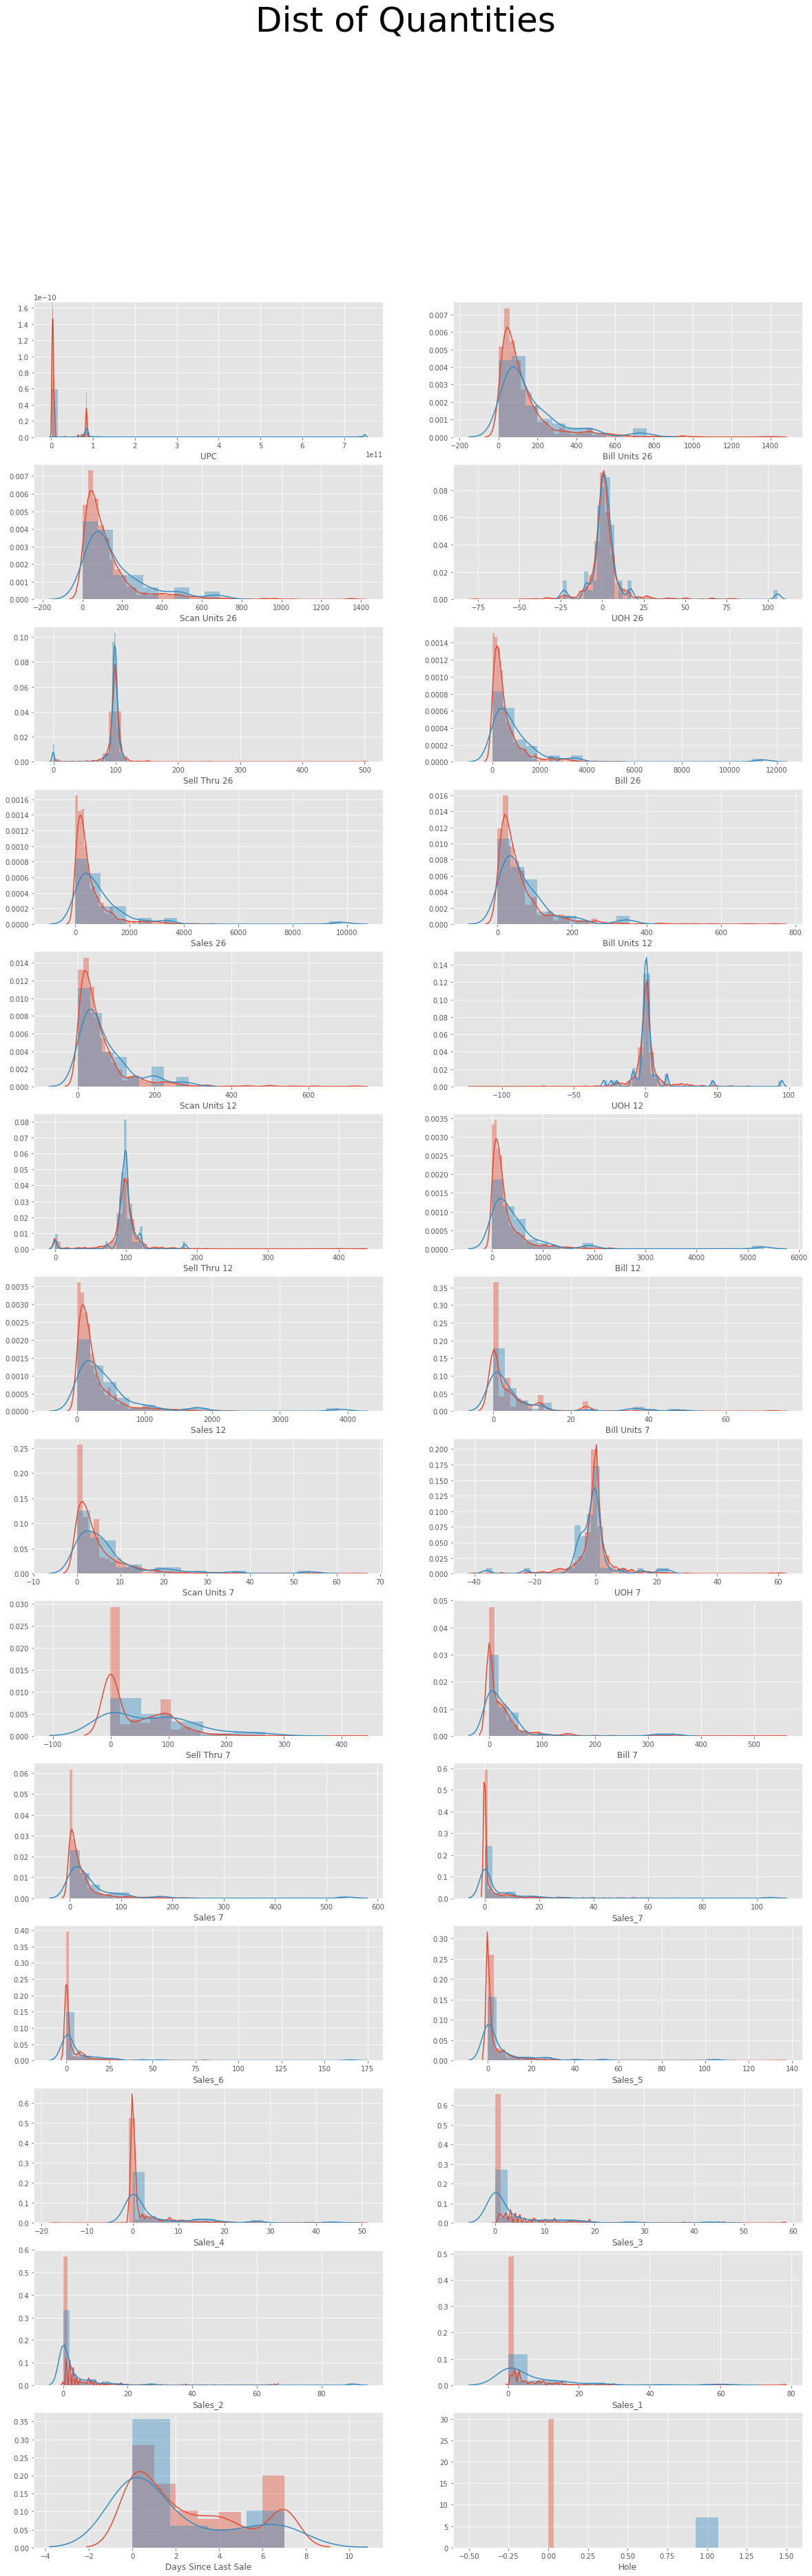

In [6]:
fig, axes = plt.subplots(14, 2, figsize = (20, 60))
fig.suptitle('Dist of Quantities', fontsize = 50);
for i, ax in enumerate(axes.flat):
    sns.distplot(other[df.columns[i]], ax = ax)
    sns.distplot(holes[df.columns[i]], ax = ax)

We definitely don't need to worry about the distribution of `UPC`s or `Holes` in this case, since 1) UPCs are just identifiers and 2) our holes are the target for our model. However, we should look more closely at our UOH estimates - since these are denoted by a function of units scanned minus units billed, and the inventory model for the store is "truck to shelf," our estimates should center around zero.

C:\Users\mulli\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


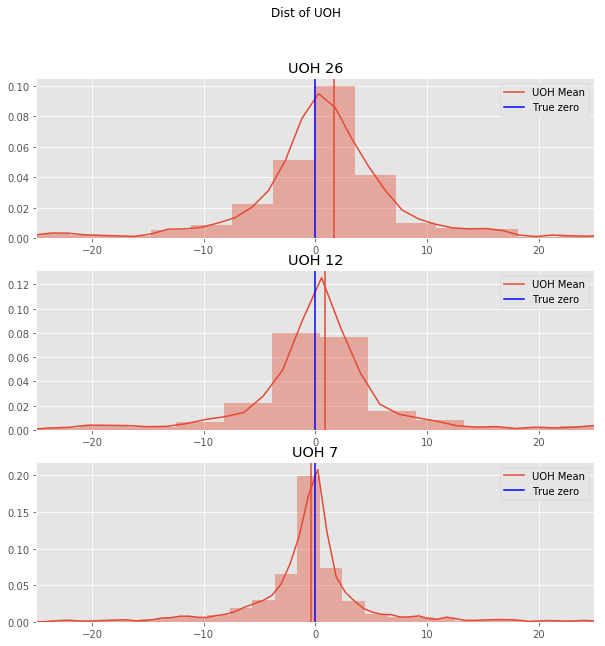

In [7]:
fig, axes = plt.subplots(3, 1, figsize = (10, 10))
fig.suptitle('Dist of UOH');

UOH = ['UOH 26', 'UOH 12', 'UOH 7']

for i, ax in enumerate(axes.flat):
    sns.distplot([df[UOH[i]]], ax = ax)
    ax.set_title(UOH[i])
    ax.axvline(x= df[UOH[i]].mean(), label = 'UOH Mean')
    ax.axvline(x = 0, label = 'True zero', color = 'b')
    ax.set_xbound(-25, 25)
    ax.legend()

So, because our inventory tries to center on an estimated 0 UOH, we should find that our `Bill Units` and `Scan Units` are more or less the same for each time period that we're able to investigate.

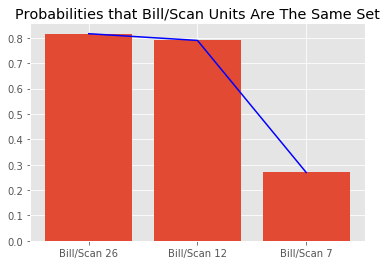

In [8]:
a = ['Bill Units 26', 'Scan Units 26']
b = ['Bill Units 12', 'Scan Units 12']
c = ['Bill Units 7', 'Scan Units 7']

check = [a,b,c]
pstat = []

for n in check:
    pstat.append(stats.f_oneway(df[n[0]], df[n[1]])[1])

plt.bar(x = ['Bill/Scan 26', 'Bill/Scan 12', 'Bill/Scan 7'], height = pstat)
plt.plot(pstat, color = 'b')
plt.title('Probabilities that Bill/Scan Units Are The Same Set');

So, in the long run since we're looking to match units ordered and units billed, it makes sense that these sets are the same across longer and longer instances of time. We would expect the same thing out of our billing and sales dollars.

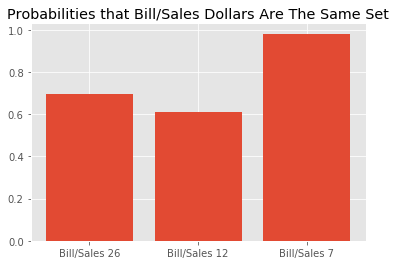

In [9]:
a = ['Bill 26', 'Sales 26']
b = ['Bill 12', 'Sales 12']
c = ['Bill 7', 'Sales 7']

check = [a,b,c]
pstat = []

for n in check:
    pstat.append(stats.f_oneway(df[n[0]], df[n[1]])[1])

plt.bar(x = ['Bill/Sales 26', 'Bill/Sales 12', 'Bill/Sales 7'], height = pstat)
plt.title('Probabilities that Bill/Sales Dollars Are The Same Set');

In [10]:
df['Bill 26'].describe()

count      963.000000
mean       599.836968
std        777.275279
min          0.000000
25%        180.000000
50%        356.000000
75%        723.500000
max      11422.000000
Name: Bill 26, dtype: float64

In [11]:
df['Sales 26'].describe()

count     963.000000
mean      586.176532
std       745.274704
min         0.000000
25%       171.000000
50%       339.000000
75%       722.500000
max      9802.000000
Name: Sales 26, dtype: float64

This was a pretty unexpected result - there's still very strong chance that they're the same set, from a statistical standpoint, but it's very surprising that it's the opposite of our exploration on billing units. I know that the reports we pulled don't include a gross margin, so I'm not sure where the disparity is coming from within the sets, nor do I know where the disparity is coming from across differences of time.

## Let's take a look at our most divergent features

I want to see if I can exaggerate the differences between our `Holes` and the remaining data, so I want to see the features we have so far that seem to be the most divergent.

In [12]:
lookup = {}
keys=[]

for column in df.columns:
    a,b = holes[column], other[column]
    result = stats.f_oneway(a,b)
    keys.append(result[0])
    lookup[result[0]] = column

keys.sort()

for i in keys[-7:]:
    print(f'{lookup[i]} has an f-stat of {i}.')

Sales_6 has an f-stat of 12.059786057189916.
Sales 12 has an f-stat of 16.49874367021207.
Sales 26 has an f-stat of 17.68554168274363.
Bill 12 has an f-stat of 19.010216154989887.
Bill 26 has an f-stat of 19.078646219914923.
Sales 7 has an f-stat of 19.994741536886217.
Sales_1 has an f-stat of 26.436970244589183.


Across our `Holes` and the other data, overall these are our 7 most divergent features. Maybe we shouldn't be surprised that the billing and sales dollars are included and not units, since when we were initially looking at sales dollars vs units the sets seemd very similar.

I want to try interacting `Sales 7` and `Sales_1`. `Sales 12` should be similar to `Bill 12` - same for `Sales 26` and `Bill 26`. I should be able to interact these two terms with each other as well as `Sales 7`, since they represent total over a longer period of time.

In [13]:
df['Sales 7*1'] = df['Sales 7'] * df['Sales_1']
df['Sales 12*26'] = (df['Sales 12'] * df['Sales 26'])/1000
df['Sales 12*7'] = (df['Sales 12'] * df['Sales 7'])/1000
df['Sales 26*7'] = (df['Sales 26'] * df['Sales 7'])/1000
holes = df.loc[df['Hole'] == 1]
other = df.loc[df['Hole'] == 0]

C:\Users\mulli\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


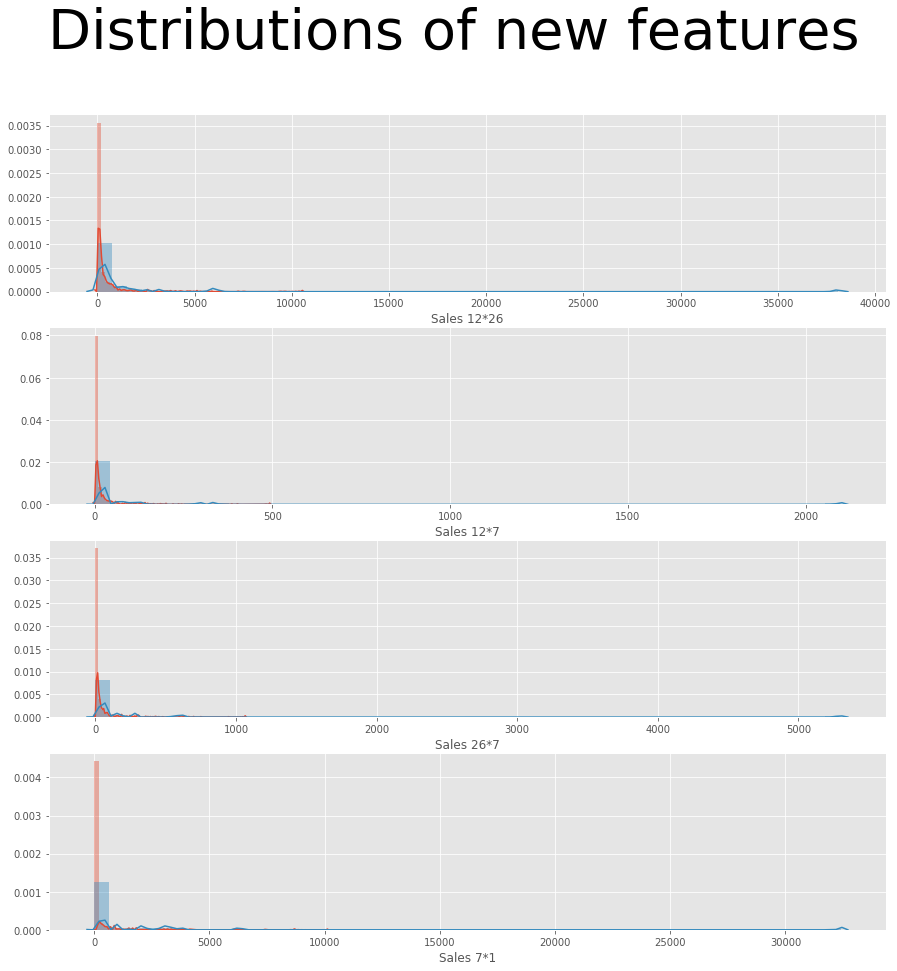

In [14]:
fig, axes = plt.subplots(4, 1, figsize =(15, 15))
fig.suptitle('Distributions of new features', fontsize = 56)

columns = ['Sales 12*26', 'Sales 12*7', 'Sales 26*7', 'Sales 7*1']
for i, ax in enumerate(axes):
    sns.distplot(other[columns[i]], ax = ax)
    sns.distplot(holes[columns[i]], ax = ax)

In [15]:
for column in columns:
    result = stats.f_oneway(other[column], holes[column])
    print(result[0])

18.681756013871567
20.936121471008782
20.652617371329352
30.309812288185427


So these features are definitely from different distributions, per our ANOVA test result. How do they compare to their parent distributions?

In [16]:
keys[-7:]

[12.059786057189916,
 16.49874367021207,
 17.68554168274363,
 19.010216154989887,
 19.078646219914923,
 19.994741536886217,
 26.436970244589183]

It looks like this was successful - we generated new features, and each one supplant something on our existing list.

# Engineering a New Feature - AIP

AIP is short for 'Average Item Price.' Since we have our sales dollars and units, deriving the average item price is as easy as dividing the total dollars by total units. Because the pet set has not just small items, say, 78 cent cans of cat food - it also has 40lb bags of food that can sell for $30+, it should have a bimodal distribution where we'd see two peaks.

Our model may be able to interpret this feature in a useful way.

In [17]:
df['AIP'] = df['Sales 26'] / df['Scan Units 26']
df['AIP'].isnull().sum()

9

In [18]:
df.loc[df['AIP'].isnull()]

,UPC,Bill Units 26,Scan Units 26,UOH 26,Sell Thru 26,Bill 26,Sales 26,Bill Units 12,Scan Units 12,UOH 12,...,Sales_3,Sales_2,Sales_1,Days Since Last Sale,Hole,Sales 7*1,Sales 12*26,Sales 12*7,Sales 26*7,AIP
274,2310013506,12,0,12,0,15,0,12.0,0.0,12.0,...,0.0,0.0,0.0,7,0.0,0.0,0.0,0.0,0.0,NaN
275,2310013507,2,0,2,0,30,0,2.0,0.0,2.0,...,0.0,0.0,0.0,7,1.0,0.0,0.0,0.0,0.0,NaN
502,4122087892,2,0,2,0,11,0,2.0,0.0,2.0,...,0.0,0.0,0.0,7,0.0,0.0,0.0,0.0,0.0,NaN
523,4122095848,12,0,12,0,12,0,12.0,0.0,12.0,...,0.0,0.0,0.0,7,0.0,0.0,0.0,0.0,0.0,NaN
526,4122096936,12,0,12,0,12,0,12.0,0.0,12.0,...,0.0,0.0,0.0,7,0.0,0.0,0.0,0.0,0.0,NaN
530,4122099346,12,0,12,0,12,0,12.0,0.0,12.0,...,0.0,0.0,0.0,7,0.0,0.0,0.0,0.0,0.0,NaN
742,7910051849,80,0,80,0,390,0,32.0,0.0,32.0,...,0.0,0.0,0.0,7,0.0,0.0,0.0,0.0,0.0,NaN
743,7910051852,76,0,76,0,402,0,32.0,0.0,32.0,...,0.0,0.0,0.0,7,0.0,0.0,0.0,0.0,0.0,NaN
962,750151480001,0,0,0,-1,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,7,1.0,0.0,0.0,0.0,0.0,NaN


It looks like we have billing dollars and units for these UPCs where AIP as determined by sales data is missing. So, we can just fill that in.

In [19]:
upcs = df.loc[df['AIP'].isnull()].UPC.ravel()
for i in upcs:
    df.loc[df['UPC'] == i, 'AIP'] = df['Bill 26'] / df['Bill Units 26']

In [20]:
df.loc[df['AIP'].isnull()]

,UPC,Bill Units 26,Scan Units 26,UOH 26,Sell Thru 26,Bill 26,Sales 26,Bill Units 12,Scan Units 12,UOH 12,...,Sales_3,Sales_2,Sales_1,Days Since Last Sale,Hole,Sales 7*1,Sales 12*26,Sales 12*7,Sales 26*7,AIP
962,750151480001,0,0,0,-1,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,7,1.0,0.0,0.0,0.0,0.0,NaN


This item that is leftover has no data at all. But, it does remind me that we replaced all the NAN values for Sell Thru with negative 1s. We encoded this feature initially to deal with situations where we sold something before there was a recorded order - which would give us a (sale)/0. We can parse this value out into a separate categorical column.

Before we do that, we'll just set the AIP for this last item to $0.

In [21]:
df.loc[df['AIP'].isnull(), 'AIP'] = 0

# Engineering Another Feature - 'Oversold'

Since this will suggest that we oversold (ie sold more than we should theoretically have) it might be a useful flag.

In [22]:
df['Oversold 26'] = 0
df.loc[df['Sell Thru 26'] == -1, 'Oversold 26'] = 1
df.loc[df['Sell Thru 26'] == -1, 'Sell Thru 26'] = 0

df['Oversold 12'] = 0
df.loc[df['Sell Thru 12'] == -1, 'Oversold 12'] = 1
df.loc[df['Sell Thru 12'] == -1, 'Sell Thru 12'] = 0

df['Oversold 7'] = 0
df.loc[df['Sell Thru 7'] == -1, 'Oversold 7'] = 1
df.loc[df['Sell Thru 7'] == -1, 'Sell Thru 7'] = 0

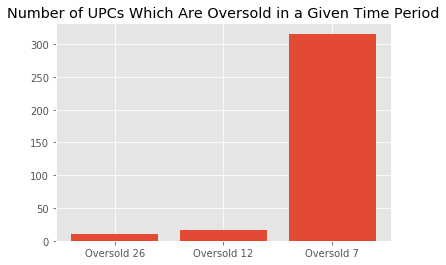

In [23]:
plt.title('Number of UPCs Which Are Oversold in a Given Time Period')
plt.bar(['Oversold 26', 'Oversold 12', 'Oversold 7'], [df['Oversold 26'].sum(), df['Oversold 12'].sum(), df['Oversold 7'].sum()]);

This makes sense - over a shorter period of time, we should be selling through product faster than we're receiving it. For example, a customer may only buy one unit at a time, but a case that comes in may contain between six and 20 units for purchase.

# Building a Feature from a Visual Inspection

It looks like `UOH 7` and `Sell Thru 7` might diverge if they interact. `UOH 7` has a negative lean - suggesting that more product has been sold than ordered, so it might be a good indicator. I'm going to try interacting these terms to see whether it will diverge. 

C:\Users\mulli\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


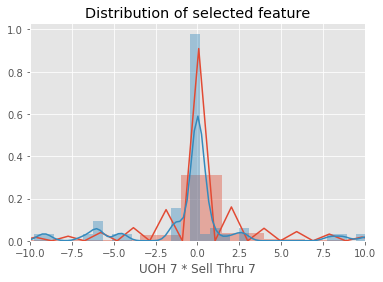

In [24]:
df['UOH 7 * Sell Thru 7'] = (df['Sell Thru 7'] * df['UOH 7'])/100
holes = df.loc[df['Hole'] == 1]
other = df.loc[df['Hole'] == 0]

sns.distplot(other['UOH 7 * Sell Thru 7'])
sns.distplot(holes['UOH 7 * Sell Thru 7'])
plt.xlim(-10, 10)
plt.title('Distribution of selected feature');

In [25]:
stats.f_oneway(other['UOH 7 * Sell Thru 7'], holes['UOH 7 * Sell Thru 7'])

F_onewayResult(statistic=1.077635509983145, pvalue=0.2994882316706067)

Unfortunately, it looks like this resulted in a convergence - our ANOVA F-stat is only 1.06, with a p value of 0.3. In other words, this interaction makes our holes look very much like the rest of our pet set, so it won't be a useful feature.

# Using SMOTE to Rebalance Our Classes

In [26]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [27]:
X = df.drop(['UPC', 'Hole'], axis = 1)
y = df.Hole

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train_resampled, y_train_resampled = SMOTE().fit_sample(X, y)

In [29]:
np.unique(y_train_resampled, return_counts = True)

(array([0., 1.]), array([907, 907], dtype=int64))

# Another Model Test

Since we've put together a few new features and balanced them out with SMOTE, it's time to see whether or not the model's performance has been improved.

In [30]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [31]:
model = XGBClassifier(n_jobs = 7)
model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=7, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [32]:
np.mean(cross_val_score(model, X_train_resampled, y_train_resampled, cv=5))

0.9449456620727339

In [33]:
confusion_matrix(y_train_resampled, model.predict(X_train_resampled))

array([[901,   6],
       [ 30, 877]], dtype=int64)

In [34]:
confusion_matrix(y_test, model.predict(np.array(X_test)))

array([[225,   1],
       [  7,   8]], dtype=int64)

This looks great, and is scoring way better than how we were doing before. Let'st take a look at our feature importances to see what's driving our new model.

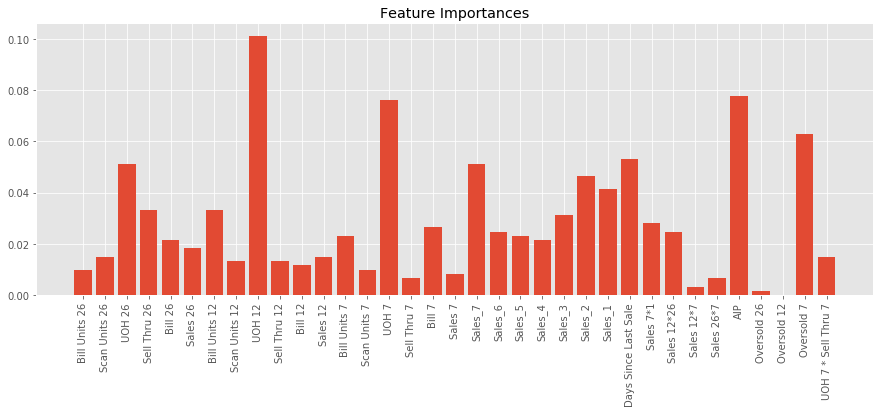

In [35]:
a = model.feature_importances_
b = list(X_test.columns)

plt.figure(figsize = (15,5))
plt.title('Feature Importances')
plt.bar(b, a)
plt.xticks(rotation = 90);

And, overall, it looks like a lot of the features we brought in were impactful. `Sales_1`, `Days Since Last Sale`, `AIP`, `Oversold 7`, all wound up significantly contributing to the model's performance.

In [36]:
zz = pd.DataFrame(confusion_matrix(y_test, model.predict(np.array(X_test))))

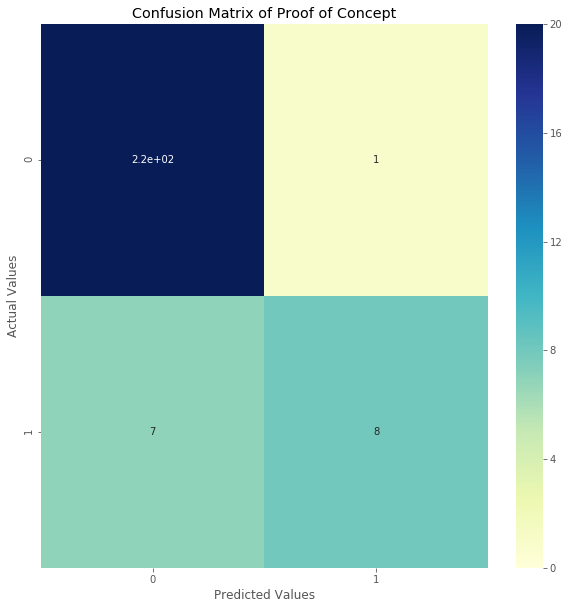

In [37]:
plt.figure(figsize = (10,10))
plt.title('Confusion Matrix of Proof of Concept')
sns.heatmap(zz, vmin = 0, vmax = 20, annot = True, cmap = "YlGnBu")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values');